# **Black Friday Sales Prediction**

### Problem Statement:

* With increasing sales of electronic goods and other provisional items during Black friday, it is important for every product chains like Walmart, BestBuy, Target etc. to know about the sale of every products based on their purchase history. 

* It will greatly help the organization chains to equip the products more efficiently based on quantity of products that had been purchased in past years. It not only helps in upkeeping the stocks of products which has been selling more, but also it will help promote the items which are not sold up to target. Analysing the data history about the product sales will greatly help in shrinking the bridge between costumer needs and product chains.

* It will also help the supply chains to improve the efficiency of target marketing based on different features of the dataset.

* With this dataset, we will be able to provide answers to following questions about the Black Friday Sales.
        1. How do people with different age genders and marital status purchase products on black friday?
        2. What is the influence of people's occupation in Black Friday sales?
        3. Do young people purchase more than older people in Black Friday?
        4. Which product categories are sold predominantly than others?
        5. Are the customers who are buying more in Black Friday, new to the city or are they staying in the same city for more years?




In [1]:
# Importing essential libraries
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import time
import gc
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.stats import norm

import statsmodels.api as sm

from sklearn.metrics import accuracy_score

from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## About Dataset:

The source of dataset is from Kaggle (https://www.kaggle.com/datasets/pranavuikey/black-friday-sales-eda). Dataset includes 550068 data records with 12 columns. 


In [2]:
# reading the dataset using pandas and displaying top 5 records of dataset
df = pd.read_csv('train.csv')
print(f"Shape: {df.shape}\n")
df.head(5)

Shape: (550068, 12)



,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
# Mapping the age feature in the readable way
print(f"Mapping Step.......\n")
print(f"\nValues in Ages before mapping: {df['Age'].unique()}\n")
age_dict = {'0-17': 'Child(Under 17)', '18-25': 'Young Adult (18-25)', '26-35': 'Mid Adult (26-35)', \
           '36-45': 'Adult Old (36-45)', '46-50': 'Old (46-50)', '51-55': 'Old Above 50', \
           '55+': 'Older above 55'}
df['Age'] = df['Age'].map(age_dict)
print(f"\nValues in Ages after mapping: {df['Age'].unique()}")

Mapping Step.......


Values in Ages before mapping: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']


Values in Ages after mapping: ['Child(Under 17)' 'Older above 55' 'Mid Adult (26-35)' 'Old (46-50)'
 'Old Above 50' 'Adult Old (36-45)' 'Young Adult (18-25)']


In [4]:
# Removing '+' at the end of '4+' in Stay_In_Current_City_Years feature
print(f"\nRemoving '+' at the end of 4+ character in Stay_In_Current_City_Years.....\n")
print(f"\nUnique values in Stay_In_Current_City_Years before removing +.....{df['Stay_In_Current_City_Years'].unique()}\n")
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].apply(lambda x: x.replace('+',''))
print(f"\nUnique values in Stay_In_Current_City_Years after removing +.....{df['Stay_In_Current_City_Years'].unique()}\n")



Removing '+' at the end of 4+ character in Stay_In_Current_City_Years.....


Unique values in Stay_In_Current_City_Years before removing +.....['2' '4+' '3' '1' '0']


Unique values in Stay_In_Current_City_Years after removing +.....['2' '4' '3' '1' '0']



In [5]:
# Updating Marital Status as Single and Married
print(f"\nUpdating Marital Status as Single and Married...\n")
print(f"\nUnique values in Marital_Status before updating +.....{df['Marital_Status'].unique()}\n")
df['Marital_Status']=df['Marital_Status'].apply(lambda x: 'Married' if x==1  else 'Single')
print(f"\nUnique values in Marital_Status after updating +.....{df['Marital_Status'].unique()}\n")


Updating Marital Status as Single and Married...


Unique values in Marital_Status before updating +.....[0 1]


Unique values in Marital_Status after updating +.....['Single' 'Married']



In [6]:
# This class is to understand the dataset more with separate dataframe and plots
class understanding_data:
    @classmethod
    def understand_data(self, df, perc_limit, n=10, col=None):
        '''
        This function is to primary function of the class which call all other sub functions in it to 
        visualize and print the summary data frame.
        :param df: DataFrame to which we need summary of to get the understanding.
        :param perc_limit: Percentage of null values in any features that we need to filter. Eg.: 0.01 for 1%.
        :param n: Default to 10. Denotes number of columns in output dataframe result.
        :param col: Default to None. If any particular column result is needed.
        :return summaryDF: DataFrame which includes 'column_name', 'column_dtype', 'unique_value_count', 'na_count'and 'na_percentage'.
        :return summaryList: List which includes all the fields of SummaryDF.
        :return df_miss: DataFrame which only includes features with missing values in it.
        '''
        summaryDF, summarList = self.summarise_col(df, col, n)
        df_miss = self.na_count(df, perc_limit)
        self.visualize_understanding(summaryDF)
        self.visualization_na(df_miss)
        return summaryDF, summarList, df_miss
    
    @classmethod
    def visualize_understanding(self, summaryDF):
        '''
        This function is to visualize the different data types of features in data frame
        :param summaryDF: DataFrame which includes 'column_name', 'column_dtype', 'unique_value_count', 'na_count'and 'na_percentage'. Output of function summarise_col.
        :returns Pie chart for distribution of data types in dataset.
        '''
        fig, ax = plt.subplots(figsize=(7,7))
        rects = summaryDF.column_dtype.value_counts().plot.pie(explode=[0.01,0.01,0.01],autopct='%1.2f%%',shadow=True)
        plt.title('Data types in Dataset')
        plt.show()
    
    @classmethod
    def summarise_col(self, df, column=None, n=10):
        '''
        This function is to create the summary data frame.
        :param df: DataFrame to which we need summary of to get the understanding.
        :param n: Default to 10. Denotes number of columns in output dataframe result.
        :param col: Default to None. If any particular column result is needed.
        :return summaryDF: DataFrame which includes 'column_name', 'column_dtype', 'unique_value_count', 'na_count'and 'na_percentage'.
        :return summaryList: List which includes all the fields of SummaryDF.
        '''
        summaryList = []
        if column is None:
            for col in df.columns:
                summaryList.append([col, df[col].dtype , df[col].nunique(), df[col].isna().sum(), df[col].isna().sum()/df.shape[0]])
        else:
            for col in column:
                summaryList.append([col, df[col].dtype(), df[col].nunique(), df[col].value_counts(), df[col].isna().sum(), df[col].isna().sum()/df.shape[0]])
        summaryDF = pd.DataFrame(summaryList[0: n+1])
        summaryDF.columns = ['column_name', 'column_dtype', 'unique_value_count', 'na_count', 'na_percentage']
        summaryDF.sort_values(by = 'na_count', ascending=False, inplace=True)
        return summaryDF, summaryList

    @classmethod
    def visualization_na(self, df_miss):
        '''
        This function is to visualize the different missing values of different features in dataframe.
        :param df_miss: DataFrame which includes 'feature_name', 'miss_value_count' and 'miss_value_percent'. Output of function na_count.
        :returns Pie chart for distribution of missing values in dataset.
        '''
        df_miss = df_miss[['miss_value_count']].drop_duplicates()
        ind = np.arange(df_miss.shape[0])
        width = 0.2
        fig, ax = plt.subplots(figsize=(7,7))
        # rects = ax.pie(ind, df_miss.miss_value_count.values)
        rects = df_miss.miss_value_count.plot.pie(autopct='%1.2f%%',shadow=True)
        ax.set_title("Missing Value Summary of various features")
        plt.show()
        

    @classmethod
    def na_count(self, df, perc_limit):
        '''
        This function is to obtain the data frame for features with missing values in it.
        :param df: DataFrame to which we need missing value distribution.
        :param perc_limit: Percentage of null values in any features that we need to filter. Eg.: 0.01 for 1%.
        :return df_miss: DataFrame which only includes features with missing values in it.
        '''
        df = df.copy()
        miss_val_cnt = df.isnull().sum().sort_values(ascending = False)
        miss_val_cnt_pcnt = (df.isnull().sum()/df.shape[0]).sort_values(ascending = False)
        df_na = pd.concat([miss_val_cnt, miss_val_cnt_pcnt], axis=1, join='outer', keys = ['miss_value_count', 'miss_value_percent'])
        df_na.index.name = 'feature_name'
        df_na.reset_index()
        df_na = df_na.sort_values(by = 'miss_value_count')
        df_na = df_na[df_na['miss_value_percent'] > perc_limit]
        return df_na

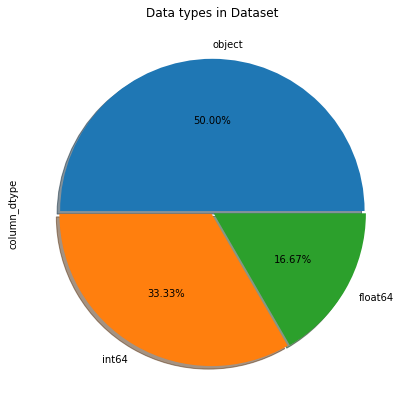

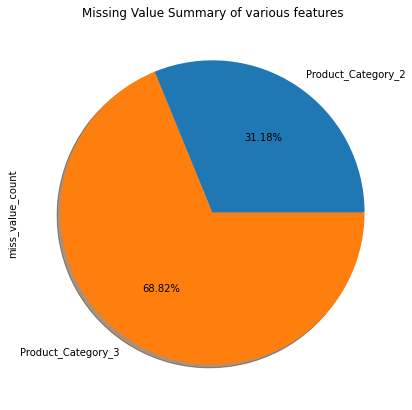

,column_name,column_dtype,unique_value_count,na_count,na_percentage
10,Product_Category_3,float64,15,383247,0.696727
9,Product_Category_2,float64,17,173638,0.315666
0,User_ID,int64,5891,0,0.000000
1,Product_ID,object,3631,0,0.000000
2,Gender,object,2,0,0.000000
3,Age,object,7,0,0.000000
4,Occupation,int64,21,0,0.000000
5,City_Category,object,3,0,0.000000
6,Stay_In_Current_City_Years,object,5,0,0.000000
7,Marital_Status,object,2,0,0.000000


In [7]:
summaryDf,_,df_miss = understanding_data.understand_data(df, 0.001, n=len(df.columns))
summaryDf

**Missing Value**
Columns *Product_Category_3* and *Product_Category_2* are the only features with missing values 
in it. It consitutes around 70% and 31% missing values respectively. 

**Unique Value Counts**
Almost most of the features available in the dataset are categorical variables. We have to apply either one-hot encoding or label encoding in order to make it as interger or float to make it easier for modelling ml algorithms.
* **One Hot Encoding:** 
* **Label Encoding:**

In [8]:
# This class is to get the unique calues in different categorical features of dataset
class categorical_nuniq_identification:
    
    @classmethod
    def cat_nuniq_less_than_10(self, df, n=10):
        '''
        This function is to primary function of the class which call all other sub functions in it to 
        visualize and unique values of categorical features in dataset.
        :param df: DataFrame to which we need summary of unique values in different features of dataset.
        :param n: Default to 10. Denotes number of columns in output dataframe result.
        :return df_nuniq: DataFrame which only includes unique values of different features in dataset.
        '''
        df = df.copy()
        cat_col = self.identifying_cat_columns(df)
        df_nuniq = self.get_cat_nuniq_less_than_10(df, cat_col, n)
        self.visualizing_cat_nuniq(df_nuniq)
        return df_nuniq
    
    @classmethod
    def identifying_cat_columns(self, df):
        '''
        This function is to identify categorical columns in dataset.
        :param df: DataFrame to which we need summary of unique values in different features of dataset.
        :return cat_columns: List of categorical features in dataset.
        '''
        num_columns = [col for col in df.columns if df[col].dtype in ('int', 'float')]
        cat_columns = list(set(df.columns) - set(num_columns))
        return cat_columns
    
    @classmethod
    def visualizing_cat_nuniq(self, df_nuniq, n=10):
        '''
        This function is to visualize and unique values of categorical features in dataset.
        :param df_nuniq: DataFrame which only includes unique values of different features in dataset. Output of function get_cat_nuniq_less_than_10
        :param n: Default to 10. Denotes number of columns in output dataframe result.
        :returns visualization plot
        '''
        df_nuniq = df_nuniq[df_nuniq['nunique_count'] <= n ]
        ind = np.arange(df_nuniq.shape[0])
        width = 0.2
        fig, ax = plt.subplots(figsize=(15,4))
        rects = ax.barh(ind, df_nuniq.nunique_count.values)
        ax.set_yticks(ind)
        ax.set_yticklabels(df_nuniq.index.values, rotation='horizontal')
        ax.set_xlabel("Unique value Count")
        ax.set_title("Features")
        plt.show()

    @classmethod
    def get_cat_nuniq_less_than_10(self, df, cat_col, n=10):
        '''
        This function is to get unique values of categorical features in dataset.
        :param df: DataFrame to which we need summary of unique values in different features of dataset.
        :param cat_col: List of categorical columns in dataset.
        :param n: Default to 10. Denotes number of columns in output dataframe result.
        :return df_nuniq: DataFrame which only includes unique values of different features in dataset.
        '''
        df = df.copy()
        total = df.shape[0]
        nuniq_list = []
        for col in df.columns[0:len(df.columns)-1]:
            nuniq = df[col].nunique()
            if nuniq <= n:
                if col in cat_col:
                    nuniq_list.append([col, 'categorical_column', nuniq, df[col].unique()])
            else:
                nuniq_list.append([col, 'numerical_column', nuniq, df[col].unique()])
        df_nuniq = pd.DataFrame(nuniq_list, columns = ['feature', 'column_type', 'nunique_count', 'unique_values_in_feature'])
        df_nuniq = df_nuniq.set_index('feature')
        df_nuniq.reset_index()
        df_nuniq = df_nuniq.sort_values(by = ['nunique_count', 'column_type'] , ascending = [False, True])
        return df_nuniq

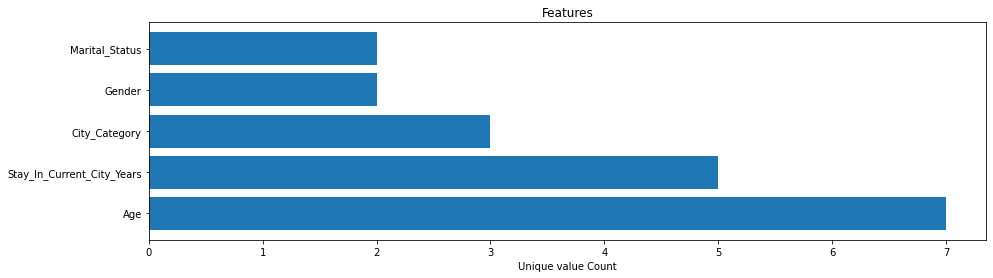

,column_type,nunique_count,unique_values_in_feature
feature,,,
User_ID,numerical_column,5891,"[1000001, 1000002, 1000003, 1000004, 1000005, ..."
Product_ID,numerical_column,3631,"[P00069042, P00248942, P00087842, P00085442, P..."
Occupation,numerical_column,21,"[10, 16, 15, 7, 20, 9, 1, 12, 17, 0, 3, 4, 11,..."
Product_Category_1,numerical_column,20,"[3, 1, 12, 8, 5, 4, 2, 6, 14, 11, 13, 15, 7, 1..."
Product_Category_2,numerical_column,17,"[nan, 6.0, 14.0, 2.0, 8.0, 15.0, 16.0, 11.0, 5..."
Product_Category_3,numerical_column,15,"[nan, 14.0, 17.0, 5.0, 4.0, 16.0, 15.0, 8.0, 9..."
Age,categorical_column,7,"[Child(Under 17), Older above 55, Mid Adult (2..."
Stay_In_Current_City_Years,categorical_column,5,"[2, 4, 3, 1, 0]"
City_Category,categorical_column,3,"[A, C, B]"


In [9]:
categorical_nuniq_identification.cat_nuniq_less_than_10(df)

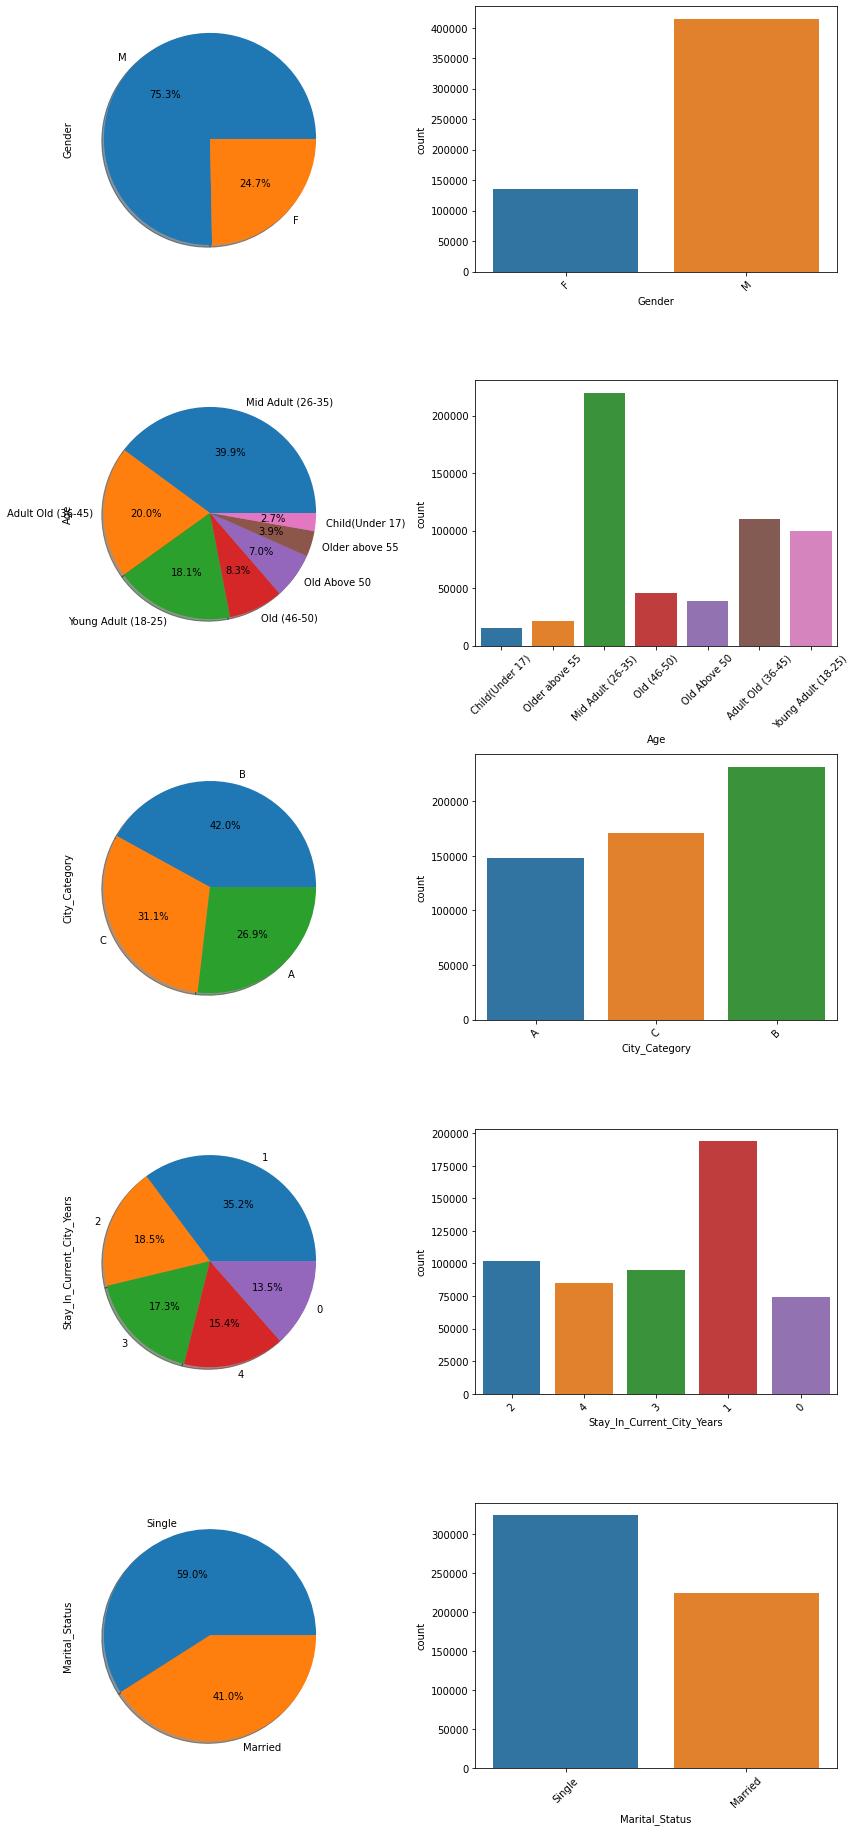

In [10]:
# To find the distribution of different values in below features of dataset
# It includes both pie chart and bar chart to visualize value counts of different values of features in dataset
cat_col = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']
count = 1
for cols in cat_col:
    plt.subplot(5, 2, count)
    df[cols].value_counts().plot.pie(shadow=True,autopct='%1.1f%%',radius=1,textprops={'fontsize': 10} )
    count +=1
    plt.subplot(5, 2, count)
    plt.tight_layout()
    sns.countplot(cols, data=df)
    fig=plt.gcf()
    fig.set_size_inches(12,25)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xticks(rotation=45)
    count+=1

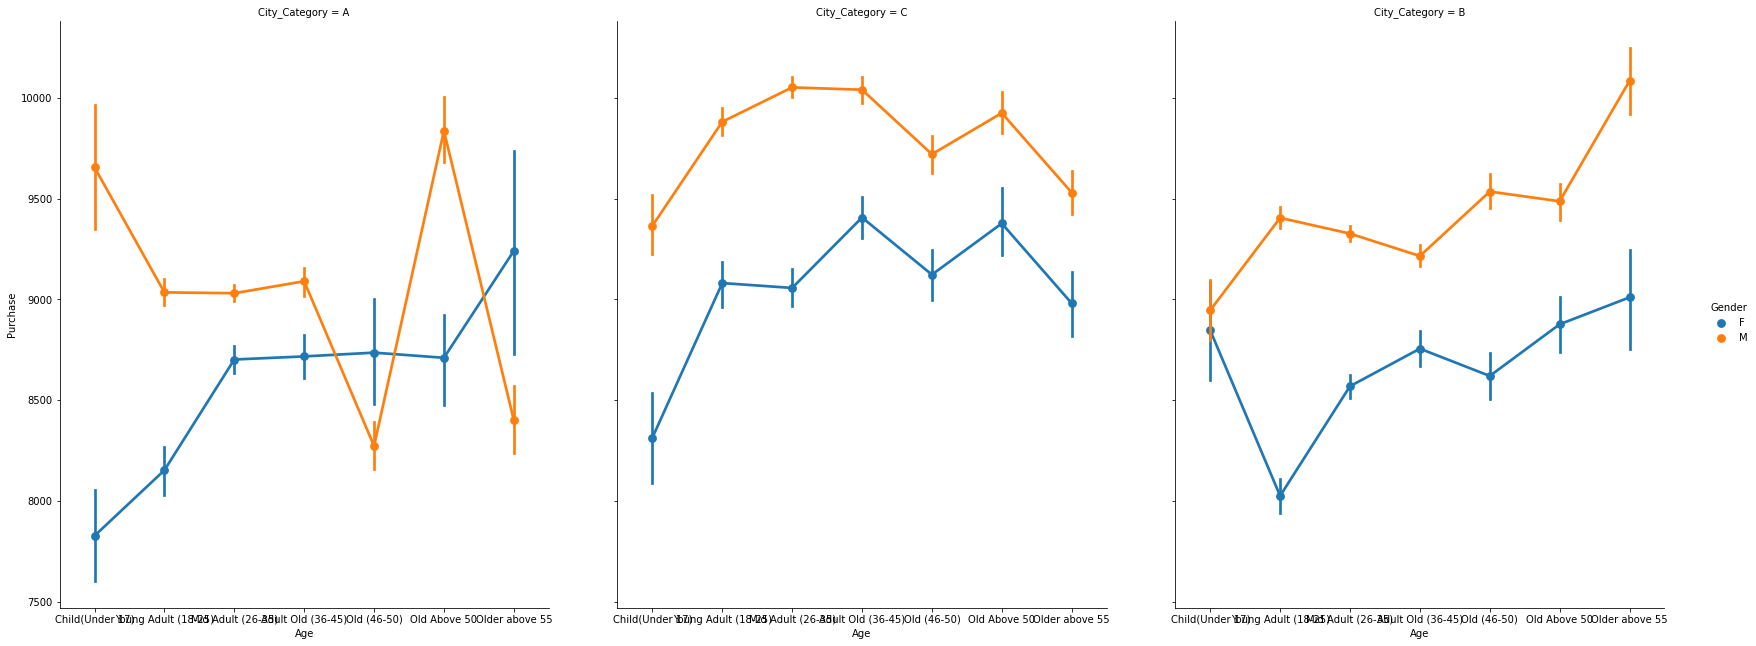

In [11]:
# catplot to visualize the trend of purchase against age, city_category and gender
sns.catplot(x='Age',y='Purchase',kind='point',data=df,
            col='City_Category',hue='Gender', 
            order=age_dict.values())
fig=plt.gcf()
fig.set_size_inches(25,10)

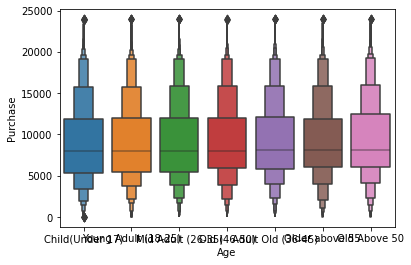

In [12]:
# Boxplot of Age Vs Purchase in ascending order of purchase
age_mode = df.groupby(['Age'])['Purchase'].median().sort_values()
sns.boxenplot(x=df['Age'], y=df['Purchase'], order=list(age_mode.index))

In [13]:
def purchase_vs_categorical(df, purchase, other_cat):
    '''
    Function to create visualization of target variable vs provided given variable. This function is to
    calculate the sum of purchases for any given category.
    :param df: Source dataframe
    :param purchase: Target Variable 'Purchase'
    :param other_cat: Categorical Variable which we need to plot against.
    '''
    part_df = df.groupby(other_cat).sum()[purchase].sort_values(ascending=False).head(10)
    part_df.index = part_df.index.astype('str')
    cap =  'Purchase vs ' + other_cat
    fig = go.Bar(x=part_df.index, y=part_df.values)
    return fig

# creating subplots to visualize sum of purchases of different categories in various features of dataset

fig = make_subplots(rows=4, cols=2, 
                   subplot_titles=['Purchase Vs User_ID',
                                  'Purchase Vs City_Category',
                                  'Purchase Vs Occupation',
                                  'Purchase Vs Gender',
                                  'Purchase Vs Age',
                                  'Purchase Vs Stay_In_Current_City_Years',
                                  'Purchase Vs Marital_Status'])

fig.add_trace(purchase_vs_categorical(df, 'Purchase', 'User_ID' ),
             row=1,col=1)

fig.add_trace(purchase_vs_categorical(df, 'Purchase', 'City_Category' ),
              row=1, col=2)

fig.add_trace(purchase_vs_categorical(df, 'Purchase', 'Occupation' ),
              row=2, col=1)

fig.add_trace(purchase_vs_categorical(df, 'Purchase', 'Gender' ),
              row=2, col=2)

fig.add_trace(purchase_vs_categorical(df, 'Purchase', 'Age' ),
              row=3, col=1)

fig.add_trace(purchase_vs_categorical(df, 'Purchase', 'Stay_In_Current_City_Years' ),
              row=3, col=2)

fig.add_trace(purchase_vs_categorical(df, 'Purchase', 'Marital_Status' ),
              row=4, col=1)

fig.update_layout(width=1000, height=1000, title = 'Purchases hold for every Categorical Variables')

fig.show()

In [14]:
# plotting the scatter chart to understand distribultion of records with respect to occupation and gender
fig = px.histogram(df, x='Occupation', width=800, height=400, facet_col="Gender",
                  title='Distribution of Records with respect to Occupation and Gender')
# showing the plot
fig.show()

Text(0.5, 1.0, 'Male Gender - Age wise data distribution')

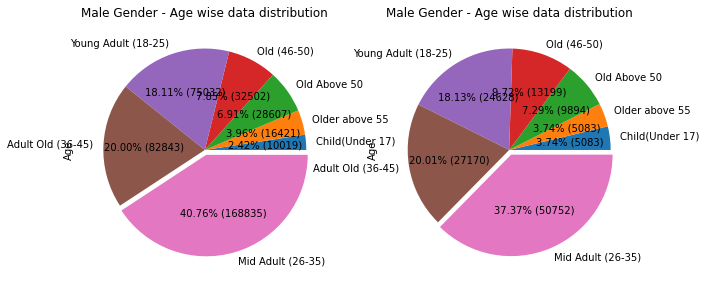

In [15]:

plt.figure(figsize=(10,10))
plt.subplot(121)
df[df['Gender']=='M']['Age'].value_counts().sort_values().plot(kind='pie',autopct=lambda p:'{:.2f}% ({:.0f})'.format(p,(p/100)*(df[df['Gender']=='M']['Age'].value_counts().sort_values()).sum()),explode=[0,0,0,0,0,0,0.05])
plt.title('Male Gender - Age wise data distribution')

plt.subplot(122)
df[df['Gender']=='F']['Age'].value_counts().sort_values().plot(kind='pie',autopct=lambda p:'{:.2f}% ({:.0f})'.format(p,(p/100)*(df[df['Gender']=='F']['Age'].value_counts().sort_values()).sum()),explode=[0,0,0,0,0,0,0.05])
plt.title('Male Gender - Age wise data distribution')

The mu 9263.968712959126 and Sigma 5023.060827959928 for the curve



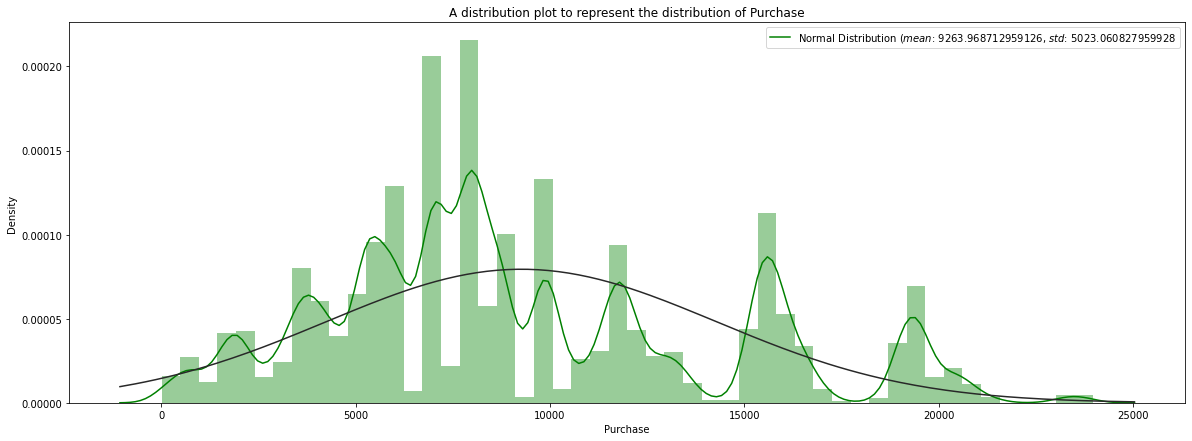

In [16]:
# plotting a distribution plot for the target variable
plt.rcParams['figure.figsize'] = (20, 7)
sns.distplot(df['Purchase'], color = 'green', fit = norm)

# fitting the target variable to the normal curve 
mean, std = norm.fit(df['Purchase']) 
print("The mu {} and Sigma {} for the curve\n".format(mean, std))

plt.title('A distribution plot to represent the distribution of Purchase')
plt.legend(['Normal Distribution ($mean$: {}, $std$: {}'.format(mean, std)], loc = 'best')
plt.show()

## Data Pre-Processing:

**Handling Missing Values**
* 1st level: Replacing na's with mode grouping by 'Gender', 'Age', 'Occupation'
* 2nd level: Replacing na's with mode grouping by 'Gender', 'Age'
* 3rd level: Replacing na's with mode grouping by 'Age'

**Handling Outliers**
* Capped outliers

In [17]:
class initial_data_pre_processing:
    '''
    This class is to handle missing values in product_category_1 and product_category_2.
    1st level: Replacing na's with mode grouping by 'Gender', 'Age', 'Occupation'
    2nd level: Replacing na's with mode grouping by 'Gender', 'Age'
    3rd level: Replacing na's with mode grouping by 'Age'
    '''
    @classmethod
    def handling_missing_data(self, df, thres=0.95):
        df = df.copy()
        df = self.impute_na(df)
        print(f'\n\nInitial Pre-Precessing Completed')
        print(f'\n\nShape of dataset after initial pre-processing is...{df.shape}')
        return df

    @classmethod
    def impute_na(self, df):
        print(f'Started Handling Missing Values...\n')
        df = df.copy()
        print(f'\nTotal null values before imputing: ', df.isnull().sum().sum())
        df_na = understanding_data.na_count(df, 0)
        all_col_na = df_na.index.tolist()
        for col in all_col_na:
            try:
                df[col] = df.groupby(['Gender', 'Age', 'Occupation'], sort = False)[col].apply(lambda x: x.fillna(x.mode().iloc[0]))
            except:
                if df.isnull().sum().sum() > 0:
                    try:
                        df[col] = df.groupby(['Gender', 'Age'], sort = False)[col].apply(lambda x: x.fillna(x.mode().iloc[0]))
                    except:
                        df[col] = df.groupby(['Age'], sort = False)[col].apply(lambda x: x.fillna(x.mode().iloc[0]))
                        df[col] = df.groupby(['Gender'], sort = False)[col].apply(lambda x: x.fillna(x.mode().iloc[0]))        
        print(f'\n\nTotal null value count after imputing: ', df.isnull().sum().sum())
        print(f'\n\nCompleted Handling Missing Values....')
        return df

In [18]:
# oh_col = ['Age', 'City_Category', 'Gender', 'Marital_Status', 'Stay_In_Current_City_Years']
df = initial_data_pre_processing.handling_missing_data(df)

Started Handling Missing Values...


Total null values before imputing:  556885


Total null value count after imputing:  0


Completed Handling Missing Values....


Initial Pre-Precessing Completed


Shape of dataset after initial pre-processing is...(550068, 12)


In [19]:
class handling_outliers:
    '''
    This class is to cap the outliers present in features 'Occupation', 'Stay_In_Current_City_Years', 'Product_Category_1',
    'Product_Category_2', 'Product_Category_3'.
    '''
    @classmethod
    def outliers_pipeline(self, df):
        df = df.copy()
        print(f'Outlier Capping.....\n\n')
        features = [col for col in df.columns if col!= 'Purchase']
        out_features = ['Occupation', 'Stay_In_Current_City_Years', 'Product_Category_1',
                       'Product_Category_2', 'Product_Category_3']
        print(f"Outliers plot before capping..\n")
        # self.visualize_outliers(df, out_features)
        df = self.capping_outliers(df, out_features) 
        print(f'\nCapping outliers completed')
        # self.visualize_outliers(df, out_features)
        print(f"\n\nOutliers plot after capping")
        return df
    
    @classmethod
    def visualize_outliers(self, df, outlier_column):
        fig = make_subplots(rows=3, cols=2, 
                           subplot_titles=['Occupation',
                                          'Stay_In_Current_City_Years',
                                          'Age',
                                          'Product_Category_1',
                                          'Product_Category_2',
                                          'Product_Category_3'])
        fig.add_trace(go.Box(y=df.Occupation.values),
                     row=1,col=1)

        fig.add_trace(go.Box(y=df.Stay_In_Current_City_Years.values),
                      row=1, col=2)

        fig.add_trace(go.Box(y=df.Age.values),
                      row=2, col=1)

        fig.add_trace(go.Box(y=df.Product_Category_1.values),
                      row=2, col=2)
        
        fig.add_trace(go.Box(y=df.Product_Category_2.values),
                      row=3, col=1)
        
        fig.add_trace(go.Box(y=df.Product_Category_3.values),
                      row=3, col=2)

        fig.update_layout(width=1000, height=1000, title = 'Outliers Plot')

        fig.show()
        
    @classmethod
    def capping_outliers(self, df, num_col):
        df = df.copy()
        df[num_col] = df[num_col].astype(int)
        for col in num_col:
            percentiles = df[col].quantile([0.10, 0.90]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        return df


In [20]:
df = handling_outliers.outliers_pipeline(df)

Outlier Capping.....


Outliers plot before capping..


Capping outliers completed


Outliers plot after capping


## Feature Selection and Engineering

* **One Hot Encoding**: Applied one hot encoding to following features 'Age', 'City_Category', 'Gender', 'Marital_Status', 'Stay_In_Current_City_Years'
    

In [21]:
class one_hot_encoding_category:   
    '''
    This class is to perform one-hot encoding to categorical columns that we provide as input.
    '''
    @classmethod
    def oh_pipeline(self, df, object_cols):
        df, dict_feature = self.one_hot_encoding(df, object_cols)
        df = self.changing_dtype_final(df, df.columns)
        return df, dict_feature
    
    
    @classmethod
    def one_hot_encoding(self, df, object_cols):
        # Apply one-hot encoder to each column with categorical data
        OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(df[object_cols]))
        OH_cols_train.columns = OH_encoder.get_feature_names_out()

        # One-hot encoding removed index; put it back
        OH_dict = {}
        for col in obj_cols:
            OH_dict[col] = [x for x in OH_cols_train.columns if x.startswith(col)]

        # Remove categorical columns (will replace with one-hot encoding)
        num_X_train = df.drop(object_cols, axis=1)

        # Add one-hot encoded columns to numerical features
        OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
        return OH_X_train, OH_dict
    

In [22]:
print(f"One Hot Encoding...")
obj_cols = ['Age', 'City_Category', 'Gender', 'Marital_Status', 'Stay_In_Current_City_Years']
print(f"\n\nColumns to be one-hot encoded: {obj_cols}")
print(f"\n\nNumber of Columns before one-hot encoding {df.shape[1]}")
df, OH_dict = one_hot_encoding_category.one_hot_encoding(df, obj_cols)
print(f"\n\nNumber of Columns after one-hot encoding {df.shape[1]}")

One Hot Encoding...


Columns to be one-hot encoded: ['Age', 'City_Category', 'Gender', 'Marital_Status', 'Stay_In_Current_City_Years']


Number of Columns before one-hot encoding 12


Number of Columns after one-hot encoding 26


In [23]:
def changing_dtype_final(df):
    '''
    This function is to change the data type of different features with float data type to int data type
    :param df: Data frame which needs data type conversion
    :return df: Data type converted data frame.
    '''
    conv_col = [col for col in df.columns if df[col].dtype == 'float']
    print(f"Changing Datatype from Float to int.....\n")
    for col in conv_col:
        df[col] = df[col].astype(int)
    print(f'\nConverted {len(conv_col)} features from float to Int...\n\n')
    return df

In [24]:
df = changing_dtype_final(df)
df.info()

Changing Datatype from Float to int.....


Converted 19 features from float to Int...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   User_ID                       550068 non-null  int64 
 1   Product_ID                    550068 non-null  object
 2   Occupation                    550068 non-null  int64 
 3   Product_Category_1            550068 non-null  int64 
 4   Product_Category_2            550068 non-null  int64 
 5   Product_Category_3            550068 non-null  int64 
 6   Purchase                      550068 non-null  int64 
 7   Age_Adult Old (36-45)         550068 non-null  int64 
 8   Age_Child(Under 17)           550068 non-null  int64 
 9   Age_Mid Adult (26-35)         550068 non-null  int64 
 10  Age_Old (46-50)               550068 non-null  int64 
 11  Age_Old Above 50             

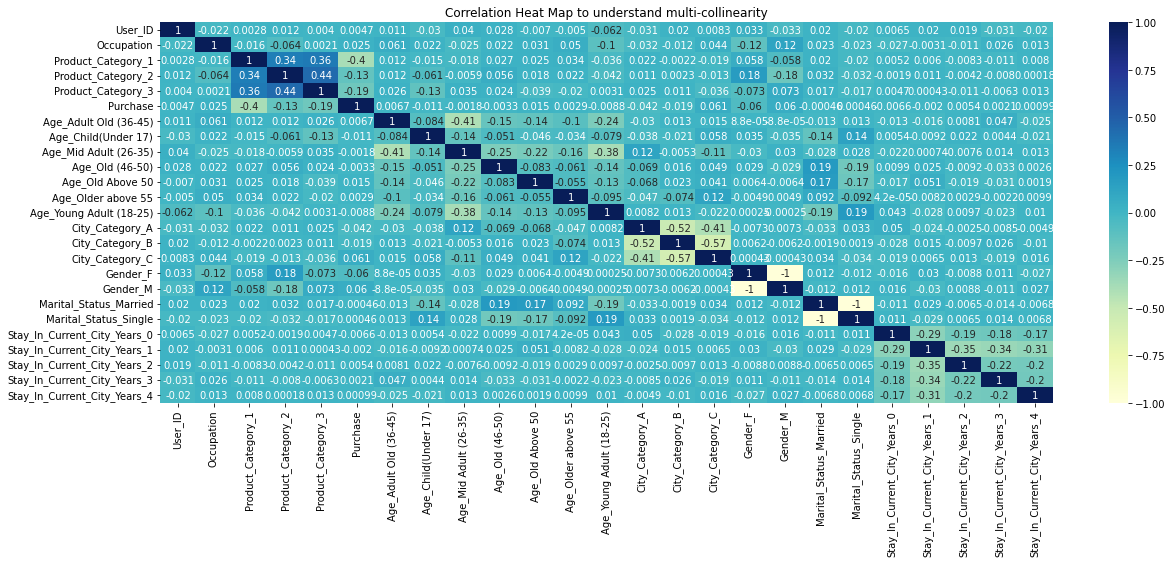

In [25]:
# Heat map to find the features with high correlation coefficient
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.title('Correlation Heat Map to understand multi-collinearity')
plt.rcParams["figure.figsize"] = (15,15)
plt.show()

In [26]:
class Feature_Engineering:
    '''
    This class is to drop columns 'User_ID' and 'Product_ID', and to remove highly correlated features.
    '''
    @classmethod
    def feature_engineering(self, df):
        # removing user and product ID as it does not hold
        print(f'\nTotal number of Columns which are present before removing user_id and product_id are {len(df.columns)}\n')
        df = df.drop(['User_ID', 'Product_ID'], axis=1)
        print(f'\nUser ID and Product ID are removed from dataset\n')
        print(f'\nTotal number of Columns which are present after removing user_id and product_id are {len(df.columns)}\n')
        df = self.dropping_high_correlated_feature(df)
        return df
    
    @classmethod
    def dropping_high_correlated_feature(self, df):
        print(f'\nRemoving Correlated Features.....\n')
        cor_matrix = df.corr().abs()
        upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
        print(f'\nColumns which are removed due to high correlation: {to_drop}\n')
        df.drop(to_drop, axis=1, inplace=True)
        print(f'\nTotal number of Columns which are present after removing highly correlated features are {len(df.columns)}')
        return df  



In [27]:
df = Feature_Engineering.feature_engineering(df)


Total number of Columns which are present before removing user_id and product_id are 26


User ID and Product ID are removed from dataset


Total number of Columns which are present after removing user_id and product_id are 24


Removing Correlated Features.....


Columns which are removed due to high correlation: ['Gender_M', 'Marital_Status_Single']


Total number of Columns which are present after removing highly correlated features are 22


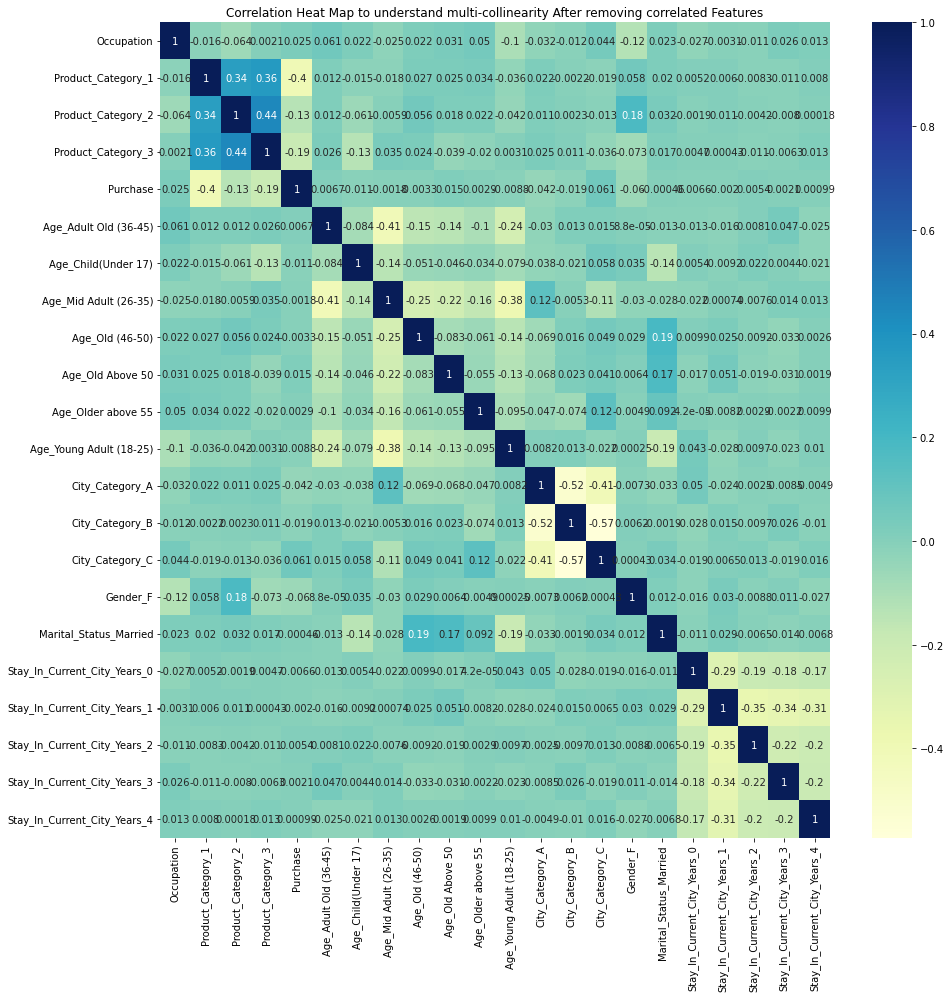

In [28]:
# Correlation plot after removing highly correlated features
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.title('Correlation Heat Map to understand multi-collinearity After removing correlated Features')
plt.rcParams["figure.figsize"] = (15,15)
plt.show()

In [29]:
def calculate_vif(data):
    '''
    This function is to calculate Variation Inflation Factor in order to eliminate multicollinearity problem created by
    one-hot encoding problem.
    '''
    vif_df = pd.DataFrame(columns = ['Feature', 'Vif', 'Feature Percentage'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif, df[df[x_var_names[i]] == 1].shape[0]/df.shape[0]]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

calculate_vif(df)

,Feature,Vif,Feature Percentage
11,Age_Young Adult (18-25),inf,0.181178
10,Age_Older above 55,inf,0.039093
20,Stay_In_Current_City_Years_3,inf,0.173224
19,Stay_In_Current_City_Years_2,inf,0.185137
18,Stay_In_Current_City_Years_1,inf,0.352358
17,Stay_In_Current_City_Years_0,inf,0.135252
14,City_Category_C,inf,0.311189
13,City_Category_B,inf,0.420263
12,City_Category_A,inf,0.268549
21,Stay_In_Current_City_Years_4,inf,0.154028


In [30]:
# df.drop(['Age_Older above 55'], axis=1, inplace=True)
# df.drop(['Stay_In_Current_City_Years_0'], axis=1, inplace=True)
# df.drop(['City_Category_A'], axis=1, inplace=True)
# df.drop(['Product_Category_3'], axis=1, inplace=True)
# dropping the colum which reduces vif from infinity
df.drop(['Age_Older above 55', 'Stay_In_Current_City_Years_0', 'City_Category_A', 'Product_Category_3'], axis=1, inplace=True)
calculate_vif(df)

,Feature,Vif,Feature Percentage
2,Product_Category_2,5.69,0.000000
6,Age_Mid Adult (26-35),5.57,0.399200
3,Purchase,4.54,0.000000
1,Product_Category_1,4.19,0.255201
4,Age_Adult Old (36-45),3.41,0.199999
14,Stay_In_Current_City_Years_1,3.31,0.352358
9,Age_Young Adult (18-25),2.95,0.181178
0,Occupation,2.60,0.086218
10,City_Category_B,2.51,0.420263
15,Stay_In_Current_City_Years_2,2.20,0.185137


In [31]:
# removing duplicates from the dataframe
print(f"\nTotal data found in dataset before dropping duplicates: {df.shape[0]}\n")
df.drop_duplicates(keep='first', inplace = True)
print(f"\nTotal data found in dataset before dropping duplicates: {df.shape[0]}\n")


Total data found in dataset before dropping duplicates: 550068


Total data found in dataset before dropping duplicates: 541332



In [32]:
X = df.loc[:, df.columns != 'Purchase']
y= df['Purchase']
X_train, X_test,y_train, y_test = train_test_split(X,y,random_state=123,test_size=0.25,
                                                   shuffle=True)

In [33]:
# Linear Regression Model
print(f'Linear Regression Model....\n')
linear_model = Pipeline(steps=[('Standardization', StandardScaler()),
                              ('linear_model', LinearRegression())
                             ])
# Preprocessing of training data, fit model 
linear_model.fit(X_train, y_train)

Linear Regression Model....



Pipeline(steps=[('Standardization', StandardScaler()),
                ('linear_model', LinearRegression())])

In [34]:
# Predicting the purchase value on test dataset
predictions = linear_model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' , y_test[:10])

Predicted labels:  [11679.  7397. 10060.  8035. 10607.  8909. 12085. 10567. 10003.  7984.]
Actual labels   :  480121     7759
183775     7953
265495     5481
536105     8026
170668    10641
328079     7138
83889     15804
388016    10915
30013      8873
250379     1961
Name: Purchase, dtype: int64


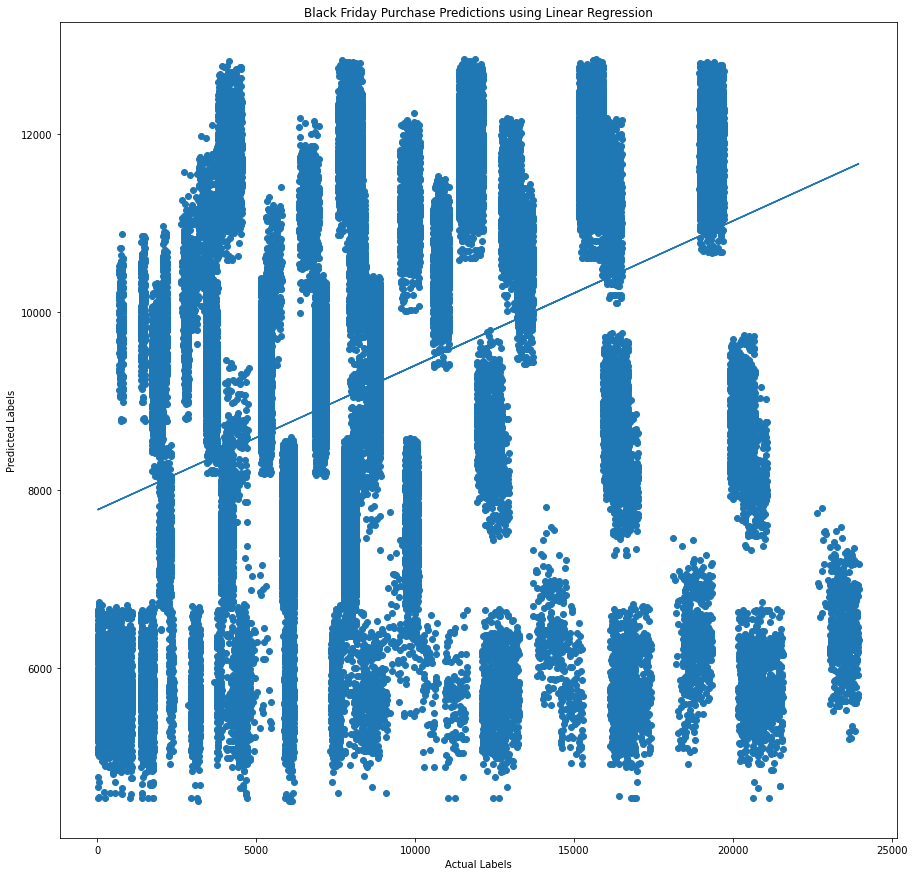

In [35]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Black Friday Purchase Predictions using Linear Regression')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test))
plt.show()

Random Forest Regressor Model.....

MSE: 12450115.8713637
RMSE: 3528.4721723946896
R2: 0.5082117288544263


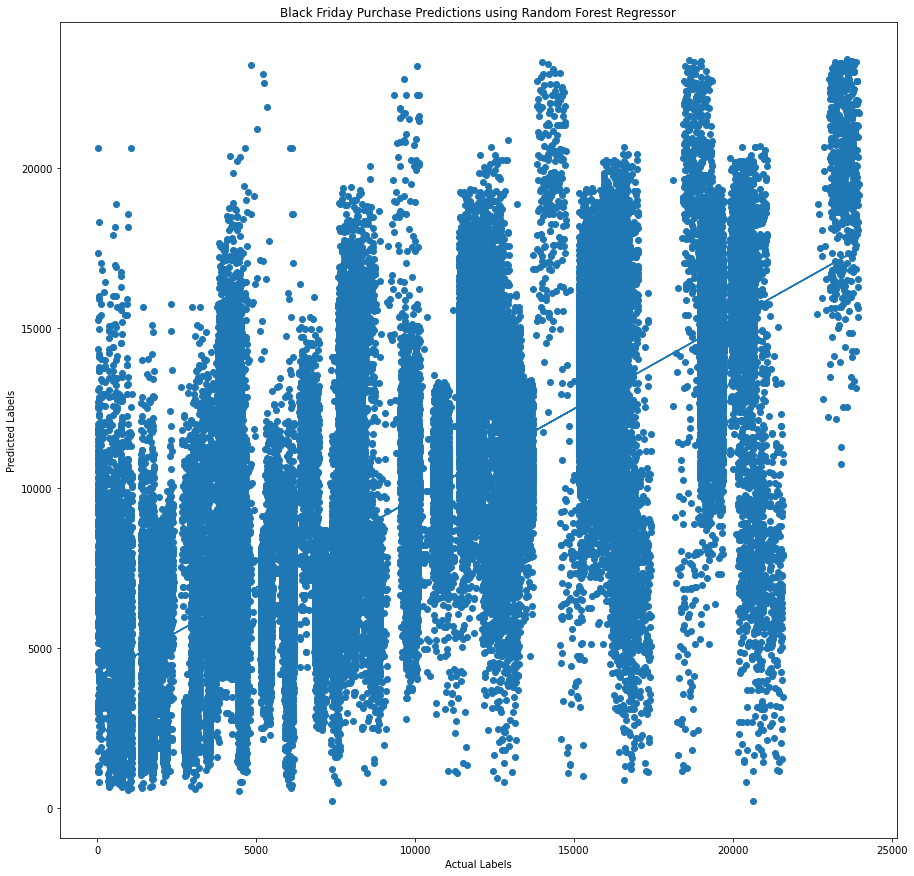

In [36]:
# Train the  random forest regressor model
print(f"Random Forest Regressor Model.....\n")
rf_model = Pipeline(steps=[('Standardization', StandardScaler()),
                              ('linear_model', RandomForestRegressor())
                             ])

rf_model.fit(X_train, y_train)

# Evaluate the model using the test data
predictions = rf_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Black Friday Purchase Predictions using Random Forest Regressor')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test))
plt.show()